In [1]:
import pandas
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy

tfd = tfp.distributions

In [5]:
url = ('https://github.com/CSSEGISandData/COVID-19/raw'
       '/master/csse_covid_19_data/csse_covid_19_time_series/'
       'time_series_covid19_confirmed_global.csv')
raw_df = pandas.read_csv(url)

In [7]:
del raw_df['Lat']
del raw_df['Long']

In [12]:
df = raw_df.set_index(['Country/Region', 'Province/State']).transpose()

In [24]:
df = df.set_index(pandas.to_datetime(df.index))

In [26]:
data = pandas.DataFrame({c: df[c].sum(axis=1) for c in df.columns.get_level_values(0)})

<AxesSubplot:>

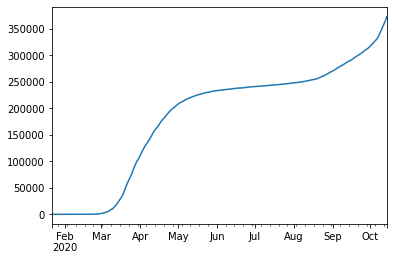

In [27]:
data['Italy'].plot()

# SIR

$$\frac{dI}{dt} = \beta \frac{SI}{N} - \gamma I$$

Here

$$R = \frac{\beta}{\gamma}$$

In [29]:
confirmed = data['Italy']

In [30]:
deltas = confirmed - confirmed.shift(1)

<AxesSubplot:>

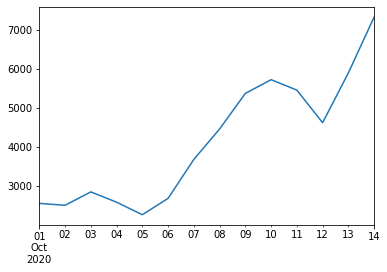

In [32]:
deltas['2020-10'].plot()

In [39]:
ks = deltas.rolling(7, win_type='gaussian').mean(std=3).dropna().round()

<AxesSubplot:>

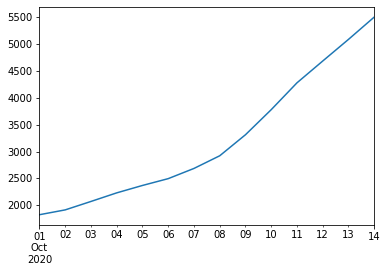

In [40]:
ks['2020-10'].plot()

# A simple model

In [41]:
Rs = tf.linspace(0.5, 2., 1000)

In [50]:
models = tfd.Poisson(rate=ks['2020-10-04']*tf.exp((Rs - 1)/5.2))

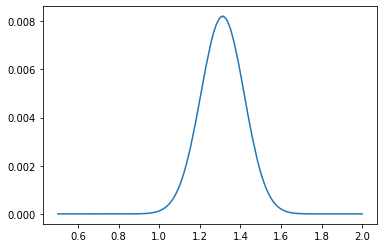

In [51]:
plt.plot(Rs, models.prob(ks['2020-10-05']))

In [46]:
ks['2020-10']

2020-10-01    1823.0
2020-10-02    1913.0
2020-10-03    2070.0
2020-10-04    2230.0
2020-10-05    2368.0
2020-10-06    2495.0
2020-10-07    2685.0
2020-10-08    2921.0
2020-10-09    3313.0
2020-10-10    3780.0
2020-10-11    4280.0
2020-10-12    4686.0
2020-10-13    5089.0
2020-10-14    5505.0
Name: Italy, dtype: float64

In [73]:
model = tfd.JointDistributionNamed({
    'R': tfd.Normal(1, 2), # prior on R
    'k': lambda R: tfd.Poisson(rate=ks['2020-10-04']*tf.exp((R - 1)/5.2))
})

In [74]:
model.resolve_graph()

(('R', ()), ('k', ('R',)))

In [75]:
model.sample()

{'R': <tf.Tensor: shape=(), dtype=float32, numpy=1.1588823>,
 'k': <tf.Tensor: shape=(), dtype=float32, numpy=2235.0>}

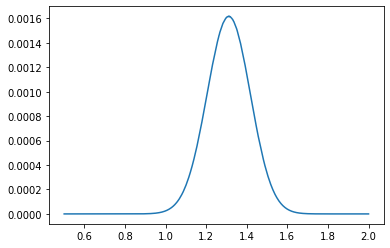

In [76]:
plt.plot(Rs, model.prob({'R': Rs, 'k': ks['2020-10-05']}))

# MAP

In [81]:
R = tf.Variable(2.)
losses = tfp.math.minimize(lambda: -model.log_prob({'R': R, 'k': ks['2020-10-05']}),
                           num_steps=500,
                           optimizer=tf.optimizers.Adam(learning_rate=0.01))

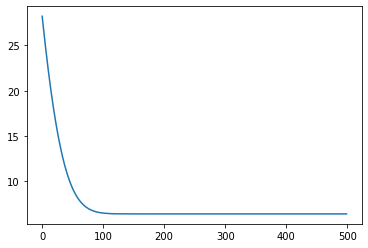

In [82]:
plt.plot(losses)

In [83]:
R

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.3113408>